In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\soybeans\pnl.csv',parse_dates=True,index_col='asofdate')

df.head()

,Unnamed: 0,pnl
asofdate,,
1969-12-22 01:00:00+00:00,0,0.0
1969-12-23 01:00:00+00:00,1,0.0
1969-12-24 01:00:00+00:00,2,0.0
1969-12-29 01:00:00+00:00,3,0.0
1969-12-30 01:00:00+00:00,4,0.0


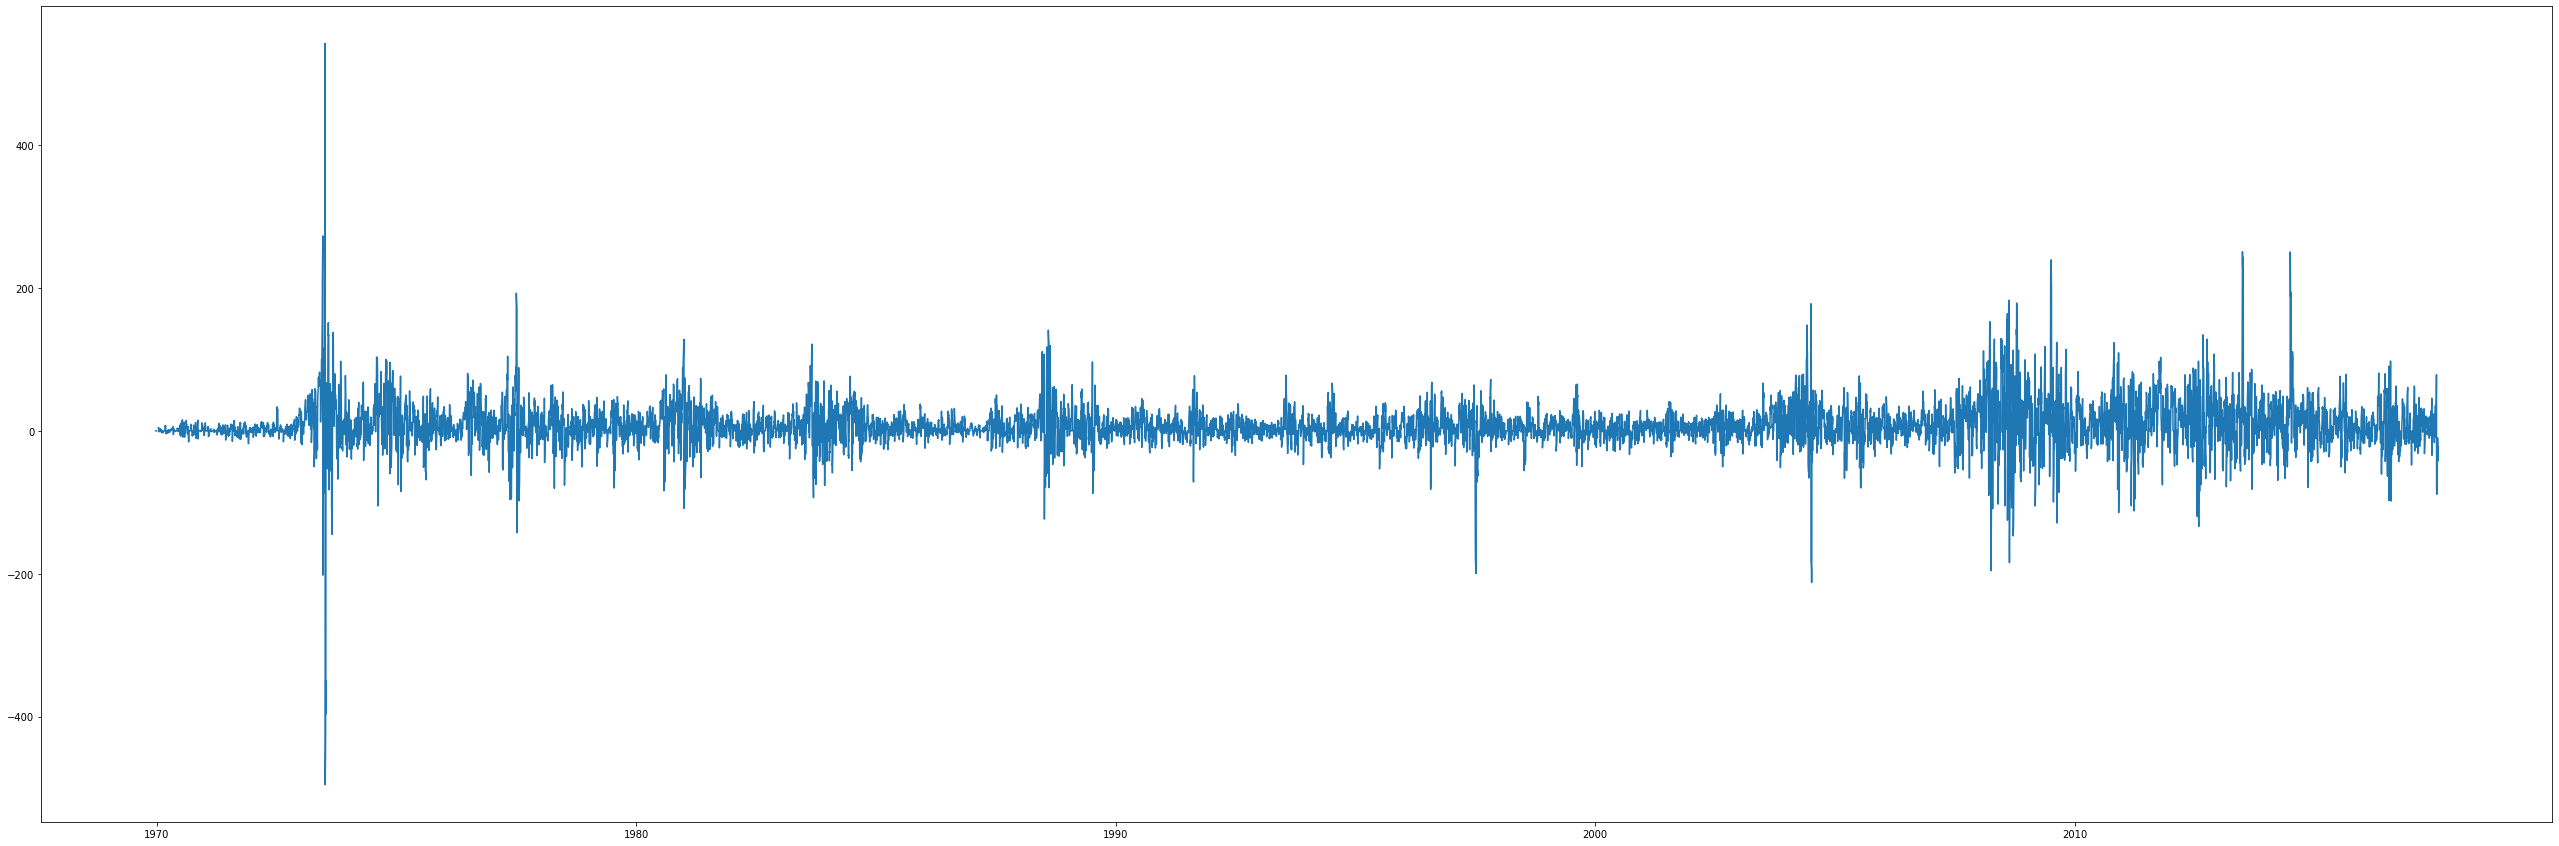

In [32]:
plt.figure(figsize=(45,15))

plt.plot(df['pnl'])

plt.show()

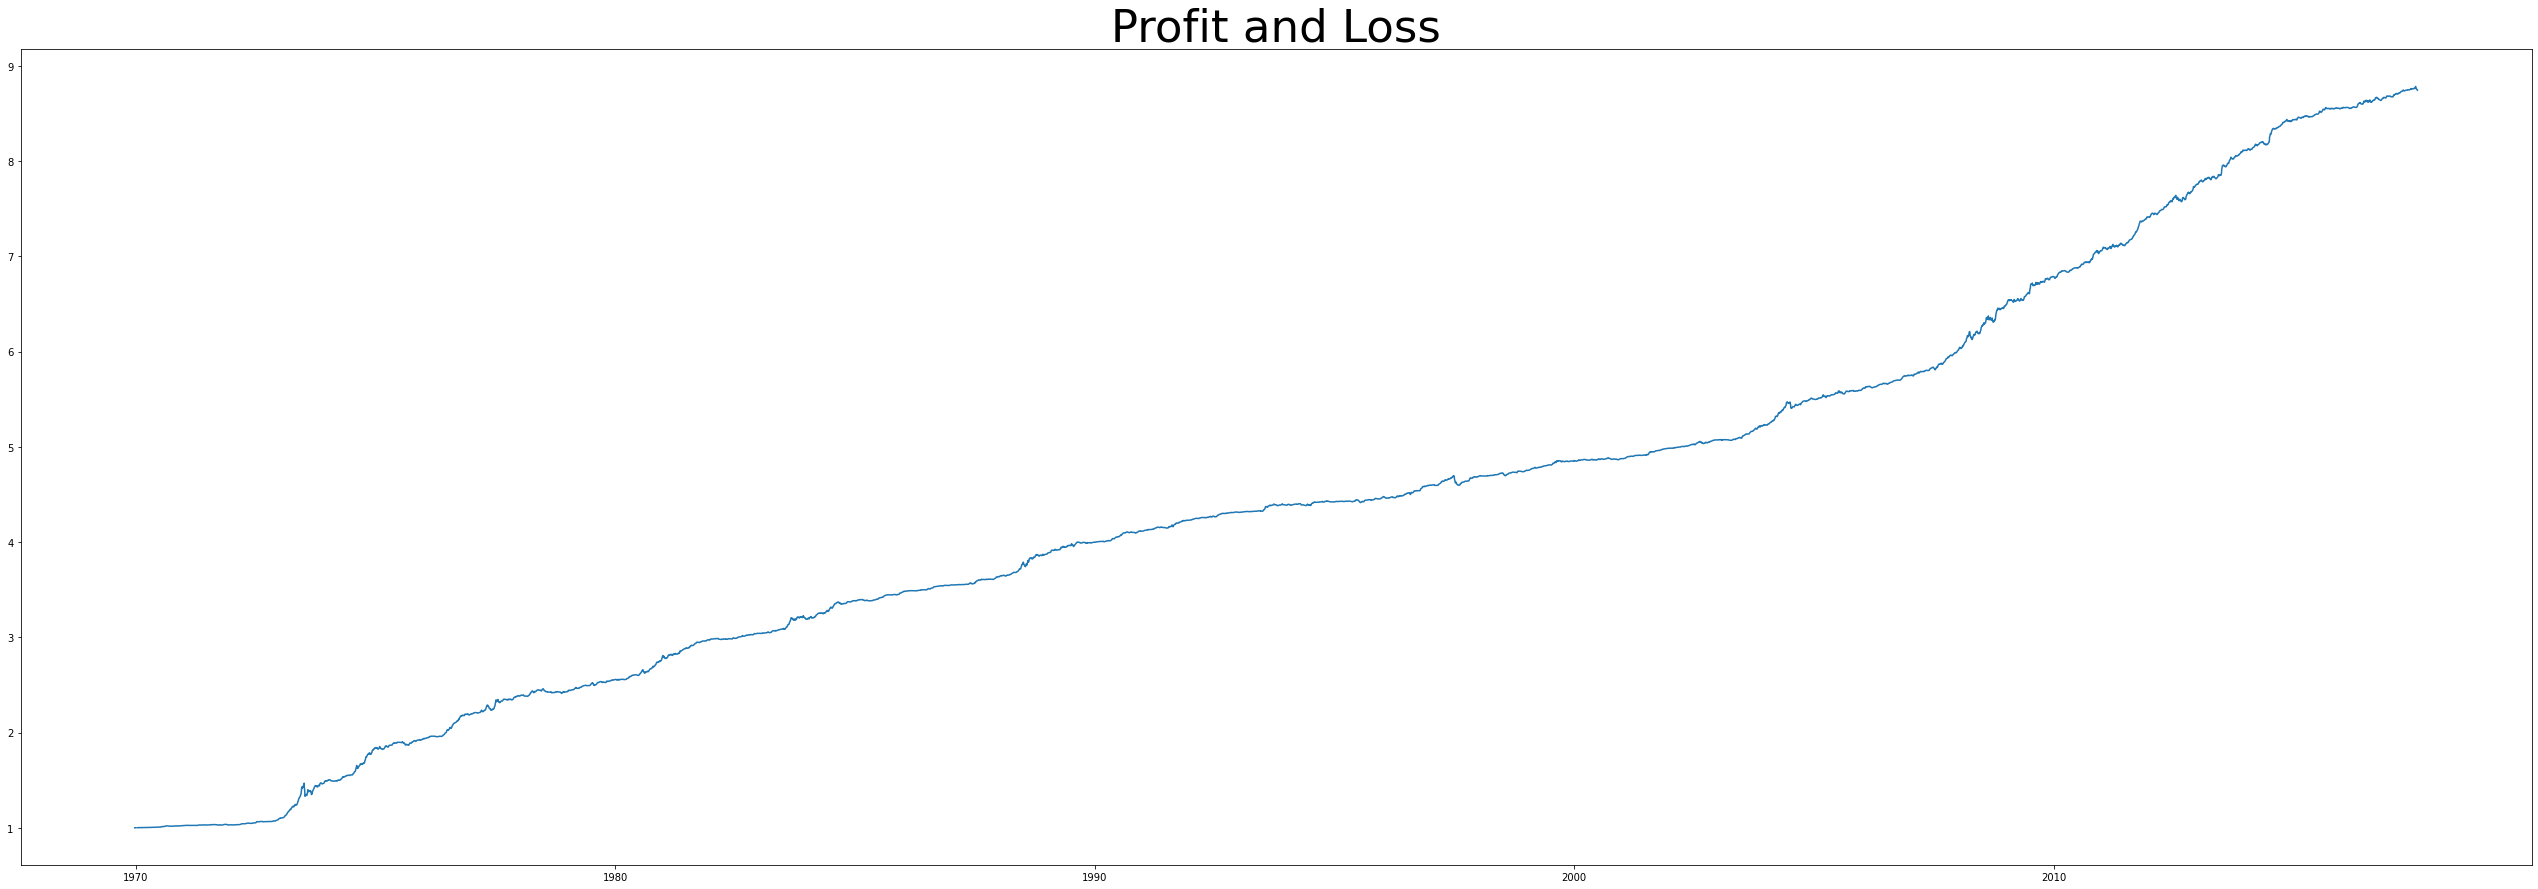

In [43]:
plt.figure(figsize=(45,15))

plt.title('Profit and Loss',fontsize=45)
plt.plot(1+df['pnl'].cumsum()/(2.44*5000))
plt.show()

In [34]:
df.head

<bound method NDFrame.head of                            Unnamed: 0    pnl
asofdate                                    
1969-12-22 01:00:00+00:00           0   0.00
1969-12-23 01:00:00+00:00           1   0.00
1969-12-24 01:00:00+00:00           2   0.00
1969-12-29 01:00:00+00:00           3   0.00
1969-12-30 01:00:00+00:00           4   0.00
...                               ...    ...
2017-07-27 00:00:00+00:00       11990 -10.50
2017-07-28 00:00:00+00:00       11991 -10.00
2017-07-31 00:00:00+00:00       11992 -41.50
2017-08-01 00:00:00+00:00       11993 -39.75
2017-08-02 00:00:00+00:00       11994 -23.00

[11995 rows x 2 columns]>

### Seasonaltiy of PnL

In [35]:
import os

os.getcwd()

'c:\\Users\\James Stanley\\Documents\\GitHub\\backtest_utilities\\pnl_analysis'

In [36]:
cumulative_pnl = df['pnl'].cumsum()/(5000*1.5429716355192085)

In [37]:
cumulative_pnl.to_csv('cumulative_pnl.csv')

# Begin experimentation

In [38]:
pnl = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\corn\cumulative_pnl.csv',parse_dates = True,index_col='asofdate')

In [39]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

class pnl_analysis_basemodel:

    def __init__(self,event):

        # Formatting dataframe
        self.dataframe          = pd.read_csv(event['dataframe'],parse_dates=True)
        self.column_name        = event['column_name']
        self.format             = event['format']
        self.date_col           = event['date_col']


        # Plots
        self.plot_annual_performance = event['plot_annual_performance']
        self.plot_seasonality        = event['plot_seasonality']
        self.seasonality             = None
        self.annual_performance      = event['annual_performance']


    def annual_decomposition(self):

        cacheYears    = [] 
        cacheDateTime = []

        for date in self.dataframe[self.date_col]:

            dateObject = datetime.datetime.strptime(date.split(" ")[0], self.format).date()

            cacheDateTime.append(dateObject)

            if str(dateObject.year) not in cacheYears:
                cacheYears.append(str(dateObject.year))

        self.dataframe[self.date_col] = cacheDateTime

        dataDict = {}

        for year in cacheYears:
            dataDict[year] = []

        for year in cacheYears:
            i = 0
            while i < len(self.dataframe):
                if year in str(self.dataframe[self.date_col][i]):
                    dataDict[year].append(self.dataframe[self.column_name][i])
                i+=1

        self.seasonality = pd.DataFrame.from_dict(dataDict,orient = 'index')
        self.seasonality = self.seasonality.T

        for year in self.seasonality.columns:
            self.seasonality[year] = self.seasonality[year].div(self.seasonality[year][0])

        self.seasonality = self.seasonality.fillna(method='ffill')

        self.seasonality = self.seasonality[np.isfinite(self.seasonality)]

        self.seasonality.to_csv(r'seasonality.csv')

        ### Above here is where we need to make an adjustment 
            ## Need to be able to analyze positions by year, month based on different factors
        
        ##############################################################################################################################################
        # Generic plots
        ##############################################################################################################################################

        if self.plot_seasonality:
 
            plt.figure(figsize=(45,15))

            plt.title('Mean',fontsize=50)

            plt.plot(self.seasonality.mean(axis=1),color='blue',linewidth='2')
            plt.plot(self.seasonality.mean(axis=1)+self.seasonality.var(axis=1),color='red',linewidth='5')
            plt.plot(self.seasonality.mean(axis=1)-self.seasonality.var(axis=1),color='red',linewidth='5')

            plt.legend(['Mean','+1std','-1std'])

            plt.show()

        if self.plot_annual_performance:
            plt.figure(figsize=(45,55))

            legend = []

            for column in self.seasonality.columns:
                plt.plot(self.seasonality[column])
                legend.append(str(column))

            plt.title('Annual Performance',fontsize=45)
            plt.legend(legend,fontsize=15)
            plt.show()

        ##############################################################################################################################################
        # Performance Analytics based on Full PNL of each position
        ##############################################################################################################################################

        if self.annual_performance:

            cacheAnnaualPerformance = {

                'year':[],
                'eoy_performance':[],
                'worst_performance':[],
                'best_performance':[],
                'variance':[],
                'stdev':[],
                'sharpe':[],
                'perf_loss':[],
                'rfr':[],

            }

            def sharpe_ratio(pnl_dataframe,rfr):

                if 0 in pnl_dataframe:

                    return 0
                else:

                    log_return = np.log(pnl_dataframe-1).diff(1)

                    return (252*(np.mean(log_return) - rfr)/np.std(log_return))**0.5


            
            # Need to add dataframe for position based pnl
                # include hitrate, win_size, loss_size, hit_rate

            for column in self.seasonality.columns:

                cacheAnnaualPerformance['year'].append(column)
                cacheAnnaualPerformance['eoy_performance'].append(self.seasonality[column][len(self.seasonality[column])-1])
                cacheAnnaualPerformance['worst_performance'].append(np.min(self.seasonality[column]))
                cacheAnnaualPerformance['best_performance'].append(np.max(self.seasonality[column])) # return index of performance
                cacheAnnaualPerformance['variance'].append(np.var(self.seasonality[column])) # return index of performance
                cacheAnnaualPerformance['stdev'].append(np.std(self.seasonality[column])) # return index of performance
                cacheAnnaualPerformance['perf_loss'] = np.array(cacheAnnaualPerformance['best_performance']) - np.array(cacheAnnaualPerformance['eoy_performance'])
                cacheAnnaualPerformance['sharpe']    = sharpe_ratio(pnl_dataframe=self.seasonality[column].fillna(0),rfr=0.02)
                cacheAnnaualPerformance['rfr'].append(0.02)
                # Add hitrate back into this equation
            self.annual_performance = pd.DataFrame(cacheAnnaualPerformance) 

        print(self.annual_performance)

        ##############################################################################################################################################
        # Generic Trade Based Analytics
        ##############################################################################################################################################
        

        # Where forecastday = 5 take pnl at that point
            # Create dictionary where keys are a dictionary wit keys asofdate and pnl with corresponding pnl and date the pnl is calculated
            # Store trade dictionary as a json file

        
        cacheTradePerformance = {
            'year':[],
            'No.Trades':[],
            'relative_pnl':[],
            'hit_rate':[],
            'Minimum':[],
            'Maximum':[],
            'Mean':[],
            'Variance':[],
            'std_dev':[],
            'skew':[],
            'kurtosis':[],

        }

        trade_identification = {'asofdate':[],'pnl':[]}

        # Dynamiacally create a dictionary where keys are year and values are key

        # print("No. Trades: ",len(short_pnl['pnl']))
        # print("relative Pnl: ", relativepnl(short_pnl['pnl']))
        # print("Hit Rate:     ", hitrate(short_pnl['pnl']))
        # print("Minimum:      ",np.min(short_pnl['pnl']))
        # print("Maximum:      ",np.max(short_pnl['pnl']))
        # print("Mean:         ",np.mean(short_pnl['pnl']))
        # print("Variance:     ",np.var(short_pnl['pnl']))
        # print("Std. Dev:     ",np.sqrt(np.var(short_pnl['pnl'])))
        # print("Skew:         ",skew(short_pnl['pnl']))
        # print("Kurtosis:     ",kurtosis(short_pnl['pnl']))

        # Save model metadata 

        return self


seasonality_event = {

    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\corn\cumulative_pnl.csv',
    'format':'%Y-%m-%d',
    'plot_annual_performance':False,
    'plot_seasonality':False,
    'annual_performance':True,
    'column_name':'pnl',
    'date_col':'asofdate',

}

seasonality(seasonality_event).annual_decomposition()

NameError: name 'seasonality' is not defined

### Test

In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

class pnl_analysis_basemodel:

    def __init__(self,event):

        # Formatting dataframe
        self.dataframe          = pd.read_csv(event['dataframe'],parse_dates=True)
        self.column_name        = event['column_name']
        self.format             = event['format']
        self.date_col           = event['date_col']


        # Plots
        self.plot_annual_performance = event['plot_annual_performance']
        self.plot_seasonality        = event['plot_seasonality']
        self.seasonality             = None
        self.annual_performance      = event['annual_performance']


    def annual_decomposition(self):

        cacheYears    = [] 
        cacheDateTime = []

        for date in self.dataframe[self.date_col]:

            dateObject = datetime.datetime.strptime(date.split(" ")[0], self.format).date()

            cacheDateTime.append(dateObject)

            if str(dateObject.year) not in cacheYears:
                cacheYears.append(str(dateObject.year))

        self.dataframe[self.date_col] = cacheDateTime

        dataDict = {}

        for year in cacheYears:
            dataDict[year] = []

        for year in cacheYears:
            i = 0
            while i < len(self.dataframe):
                if year in str(self.dataframe[self.date_col][i]):
                    dataDict[year].append(self.dataframe[self.column_name][i])
                i+=1

        self.seasonality = pd.DataFrame.from_dict(dataDict,orient = 'index')
        self.seasonality = self.seasonality.T

        for year in self.seasonality.columns:
            self.seasonality[year] = self.seasonality[year].div(self.seasonality[year][0])

        self.seasonality = self.seasonality.fillna(method='ffill')

        self.seasonality = self.seasonality[np.isfinite(self.seasonality)]

        self.seasonality.to_csv(r'seasonality.csv')

        ### Above here is where we need to make an adjustment 
            ## Need to be able to analyze positions by year, month based on different factors
        
        ##############################################################################################################################################
        # Generic plots
        ##############################################################################################################################################

        if self.plot_seasonality:
 
            plt.figure(figsize=(45,15))

            plt.title('Mean',fontsize=50)

            plt.plot(self.seasonality.mean(axis=1),color='blue',linewidth='2')
            plt.plot(self.seasonality.mean(axis=1)+self.seasonality.var(axis=1),color='red',linewidth='5')
            plt.plot(self.seasonality.mean(axis=1)-self.seasonality.var(axis=1),color='red',linewidth='5')

            plt.legend(['Mean','+1std','-1std'])

            plt.show()

        if self.plot_annual_performance:
            plt.figure(figsize=(45,55))

            legend = []

            for column in self.seasonality.columns:
                plt.plot(self.seasonality[column])
                legend.append(str(column))

            plt.title('Annual Performance',fontsize=45)
            plt.legend(legend,fontsize=15)
            plt.show()

        ##############################################################################################################################################
        # Performance Analytics based on Full PNL of each position
        ##############################################################################################################################################

        if self.annual_performance:

            cacheAnnaualPerformance = {

                'year':[],
                'eoy_performance':[],
                'worst_performance':[],
                'best_performance':[],
                'variance':[],
                'stdev':[],
                'sharpe':[],
                'perf_loss':[],
                'rfr':[],

            }

            def sharpe_ratio(pnl_dataframe,rfr):

                if 0 in pnl_dataframe:

                    return 0
                else:

                    log_return = np.log(pnl_dataframe-1).diff(1)

                    return (252*(np.mean(log_return) - rfr)/np.std(log_return))**0.5


            
            # Need to add dataframe for position based pnl
                # include hitrate, win_size, loss_size, hit_rate

            for column in self.seasonality.columns:

                cacheAnnaualPerformance['year'].append(column)
                cacheAnnaualPerformance['eoy_performance'].append(self.seasonality[column][len(self.seasonality[column])-1])
                cacheAnnaualPerformance['worst_performance'].append(np.min(self.seasonality[column]))
                cacheAnnaualPerformance['best_performance'].append(np.max(self.seasonality[column])) # return index of performance
                cacheAnnaualPerformance['variance'].append(np.var(self.seasonality[column])) # return index of performance
                cacheAnnaualPerformance['stdev'].append(np.std(self.seasonality[column])) # return index of performance
                cacheAnnaualPerformance['perf_loss'] = np.array(cacheAnnaualPerformance['best_performance']) - np.array(cacheAnnaualPerformance['eoy_performance'])
                cacheAnnaualPerformance['sharpe']    = sharpe_ratio(pnl_dataframe=self.seasonality[column].fillna(0),rfr=0.02)
                cacheAnnaualPerformance['rfr'].append(0.02)

            self.annual_performance = pd.DataFrame(cacheAnnaualPerformance) 

        print(self.annual_performance)

        ##############################################################################################################################################
        # Generic Trade Based Analytics
        ##############################################################################################################################################
        

        # Where forecastday = 5 take pnl at that point
            # Create dictionary where keys are a dictionary wit keys asofdate and pnl with corresponding pnl and date the pnl is calculated
            # Store trade dictionary as a json file

        
        cacheTradePerformance = {
            'year':[],
            'No.Trades':[],
            'relative_pnl':[],
            'hit_rate':[],
            'Minimum':[],
            'Maximum':[],
            'Mean':[],
            'Variance':[],
            'std_dev':[],
            'skew':[],
            'kurtosis':[],

        }

        trade_identification = {'asofdate':[],'pnl':[]}

        # Dynamiacally create a dictionary where keys are year and values are key

        # print("No. Trades: ",len(short_pnl['pnl']))
        # print("relative Pnl: ", relativepnl(short_pnl['pnl']))
        # print("Hit Rate:     ", hitrate(short_pnl['pnl']))
        # print("Minimum:      ",np.min(short_pnl['pnl']))
        # print("Maximum:      ",np.max(short_pnl['pnl']))
        # print("Mean:         ",np.mean(short_pnl['pnl']))
        # print("Variance:     ",np.var(short_pnl['pnl']))
        # print("Std. Dev:     ",np.sqrt(np.var(short_pnl['pnl'])))
        # print("Skew:         ",skew(short_pnl['pnl']))
        # print("Kurtosis:     ",kurtosis(short_pnl['pnl']))

        # Save model metadata 

        return self


seasonality_event = {

    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\corn\cumulative_pnl.csv',
    'format':'%Y-%m-%d',
    'plot_annual_performance':False,
    'plot_seasonality':False,
    'annual_performance':True,
    'column_name':'pnl',
    'date_col':'asofdate',

}

seasonality(seasonality_event).annual_decomposition()

### Test End

In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

class baseObject:

    def __init__(self,event):

        # Formatting dataframe
        self.dataframe   = pd.read_csv(event['dataframe'],parse_dates=True)
        self.column_name = event['column_name']
        self.format      = event['format']
        self.date_col    = event['date_col']
        self.seasonality = None
        self.years       = []
        self.dateTime    = []

        for date in self.dataframe[self.date_col]:

            dateObject = datetime.datetime.strptime(date.split(" ")[0], self.format).date()

            self.dateTime.append(dateObject)

            if str(dateObject.year) not in self.years:
                self.years.append(str(dateObject.year))

        self.dataframe[self.date_col] = self.dateTime

        dataDict = {}

        for year in self.years:
            dataDict[year] = []

        for year in self.years:
            i = 0
            while i < len(self.dataframe):
                if year in str(self.dataframe[self.date_col][i]):
                    dataDict[year].append(self.dataframe[self.column_name][i])
                i+=1

        self.seasonality = pd.DataFrame.from_dict(dataDict,orient = 'index')
        self.seasonality = self.seasonality.T

        for year in self.seasonality.columns:
            self.seasonality[year] = self.seasonality[year].div(self.seasonality[year][0])

        self.seasonality = self.seasonality.fillna(method='ffill')
        self.seasonality = self.seasonality[np.isfinite(self.seasonality)]

In [ ]:
class annualPerformance(baseObject):

    def __init__(self,event):
        super().__init__(self,event)

    def plot_seasonality(self):
 
            plt.figure(figsize=(45,15)) # This size should be read in later

            plt.title('Mean',fontsize=50)

            plt.plot(self.seasonality.mean(axis=1),color='blue',linewidth='2')
            plt.plot(self.seasonality.mean(axis=1)+self.seasonality.var(axis=1),color='red',linewidth='5')
            plt.plot(self.seasonality.mean(axis=1)-self.seasonality.var(axis=1),color='red',linewidth='5')

            plt.legend(['Mean','+1std','-1std'])

            plt.show()

    def plot_annual_performance(self):
        
        plt.figure(figsize=(45,55))

        legend = []

        for column in self.seasonality.columns:
            plt.plot(self.seasonality[column])
            legend.append(str(column))

        plt.title('Annual Performance',fontsize=45)
        plt.legend(legend,fontsize=15)
        plt.show()

    def annualPerformance(self):

        cacheAnnaualPerformance = {

            'year':[],
            'eoy_performance':[],
            'worst_performance':[],
            'best_performance':[],
            'variance':[],
            'stdev':[],
            'sharpe':[],
            'perf_loss':[],
            'rfr':[],

        }

        def sharpe_ratio(pnl_dataframe,rfr):

            if 0 in pnl_dataframe:

                return 0
            else:

                log_return = np.log(pnl_dataframe-1).diff(1)

                return (252*(np.mean(log_return) - rfr)/np.std(log_return))**0.5

        for column in self.seasonality.columns:

            cacheAnnaualPerformance['year'].append(column)
            cacheAnnaualPerformance['eoy_performance'].append(self.seasonality[column][len(self.seasonality[column])-1])
            cacheAnnaualPerformance['worst_performance'].append(np.min(self.seasonality[column]))
            cacheAnnaualPerformance['best_performance'].append(np.max(self.seasonality[column])) # return index of performance
            cacheAnnaualPerformance['variance'].append(np.var(self.seasonality[column])) # return index of performance
            cacheAnnaualPerformance['stdev'].append(np.std(self.seasonality[column])) # return index of performance
            cacheAnnaualPerformance['perf_loss'] = np.array(cacheAnnaualPerformance['best_performance']) - np.array(cacheAnnaualPerformance['eoy_performance'])
            cacheAnnaualPerformance['sharpe'] = sharpe_ratio(pnl_dataframe=self.seasonality[column].fillna(0),rfr=0.02)
            cacheAnnaualPerformance['rfr'].append(0.02)

        self.annual_performance = pd.DataFrame(cacheAnnaualPerformance) 


    def plot_seasonality(self):

        plt.figure(figsize=(45,15))

        plt.title('Mean',fontsize=50)

        plt.plot(self.seasonality.mean(axis=1),color='blue',linewidth='2')
        plt.plot(self.seasonality.mean(axis=1)+self.seasonality.var(axis=1),color='red',linewidth='5')
        plt.plot(self.seasonality.mean(axis=1)-self.seasonality.var(axis=1),color='red',linewidth='5')

        plt.legend(['Mean','+1std','-1std'])

        plt.show()

    def plot_annual_performance(self):
        
        plt.figure(figsize=(45,55))

        legend = []

        for column in self.seasonality.columns:
            plt.plot(self.seasonality[column])
            legend.append(str(column))

        plt.title('Annual Performance',fontsize=45)
        plt.legend(legend,fontsize=15)
        plt.show()


In [ ]:
class tradePerformance(baseObject):

    def __init__(self,event):
        super().__init__(self,event)

        self.cacheTradePerformance =  {

            'year':[],
            'No.Trades':[],
            'relative_pnl':[],
            'hit_rate':[],
            'min_pnl':[],
            'max_pnl':[],
            'mean':[],
            'Variance':[],
            'std_dev':[],
            'skew':[],
            'kurtosis':[],

        }

    def positionPerformance(self):

        from scipy.stats import skew, kurtosis

        def hitrate(self):

            up = 0
            down = 0
            for p in pnl:

                if p < 0:
                    down+=1
                if p > 0:
                    up+=1

            return up / (up + down)
        
        def relativepnl(self):

            up = 0
            down = 0
            for p in self.pnl:

                if p < 0:
                    down+=p
                if p > 0:
                    up+=p
            return up / (down)

        for year in self.years:
                    
        # Need to add dataframe for position based pnl
            # include hitrate, win_size, loss_size, hit_rate

            self.cacheTradePerformance['No.Trades'].append(np.len(self.seasonality[year]))
            self.cacheTradePerformance['relative_pnl'].append(relativepnl(self.seasonality[year]))
            self.cacheTradePerformance['hit_rate'].append(hitrate(self.seasonality[year]))
            self.cacheTradePerformance['min_pnl'].append(np.min(self.seasonality[year]))
            self.cacheTradePerformance['max_pnl'].append(np.max(self.seasonality[year]))
            self.cacheTradePerformance['Mean'].append(np.mean(self.seasonality[year]))
            self.cacheTradePerformance['Variance'].append(np.var(self.seasonality[year]))
            self.cacheTradePerformance['std_dev'].append(np.std(self.seasonality[year]))
            self.cacheTradePerformance['skew'].append(skew(self.seasonality[year]))
            self.cacheTradePerformance['kurtosis'].append(kurtosis(self.seasonality[year])) 

        return self.cacheTradePerformance

In [ ]:
pnl_event = {

    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\corn\cumulative_pnl.csv',
    'format':'%Y-%m-%d',
    'column_name':'pnl',
    'date_col':'asofdate',

}

In [ ]:
pabObject = baseObject(pnl_event)

In [ ]:
seasonality_event = {

    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\corn\cumulative_pnl.csv',
    'format':'%Y-%m-%d',
    'column_name':'pnl',
    'date_col':'asofdate',

}

In [ ]:
s_object = annualPerformance(pabObject)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
s_object.seasonality

# Scatter

In [ ]:
scatter_df = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\corn\forecasts.csv')

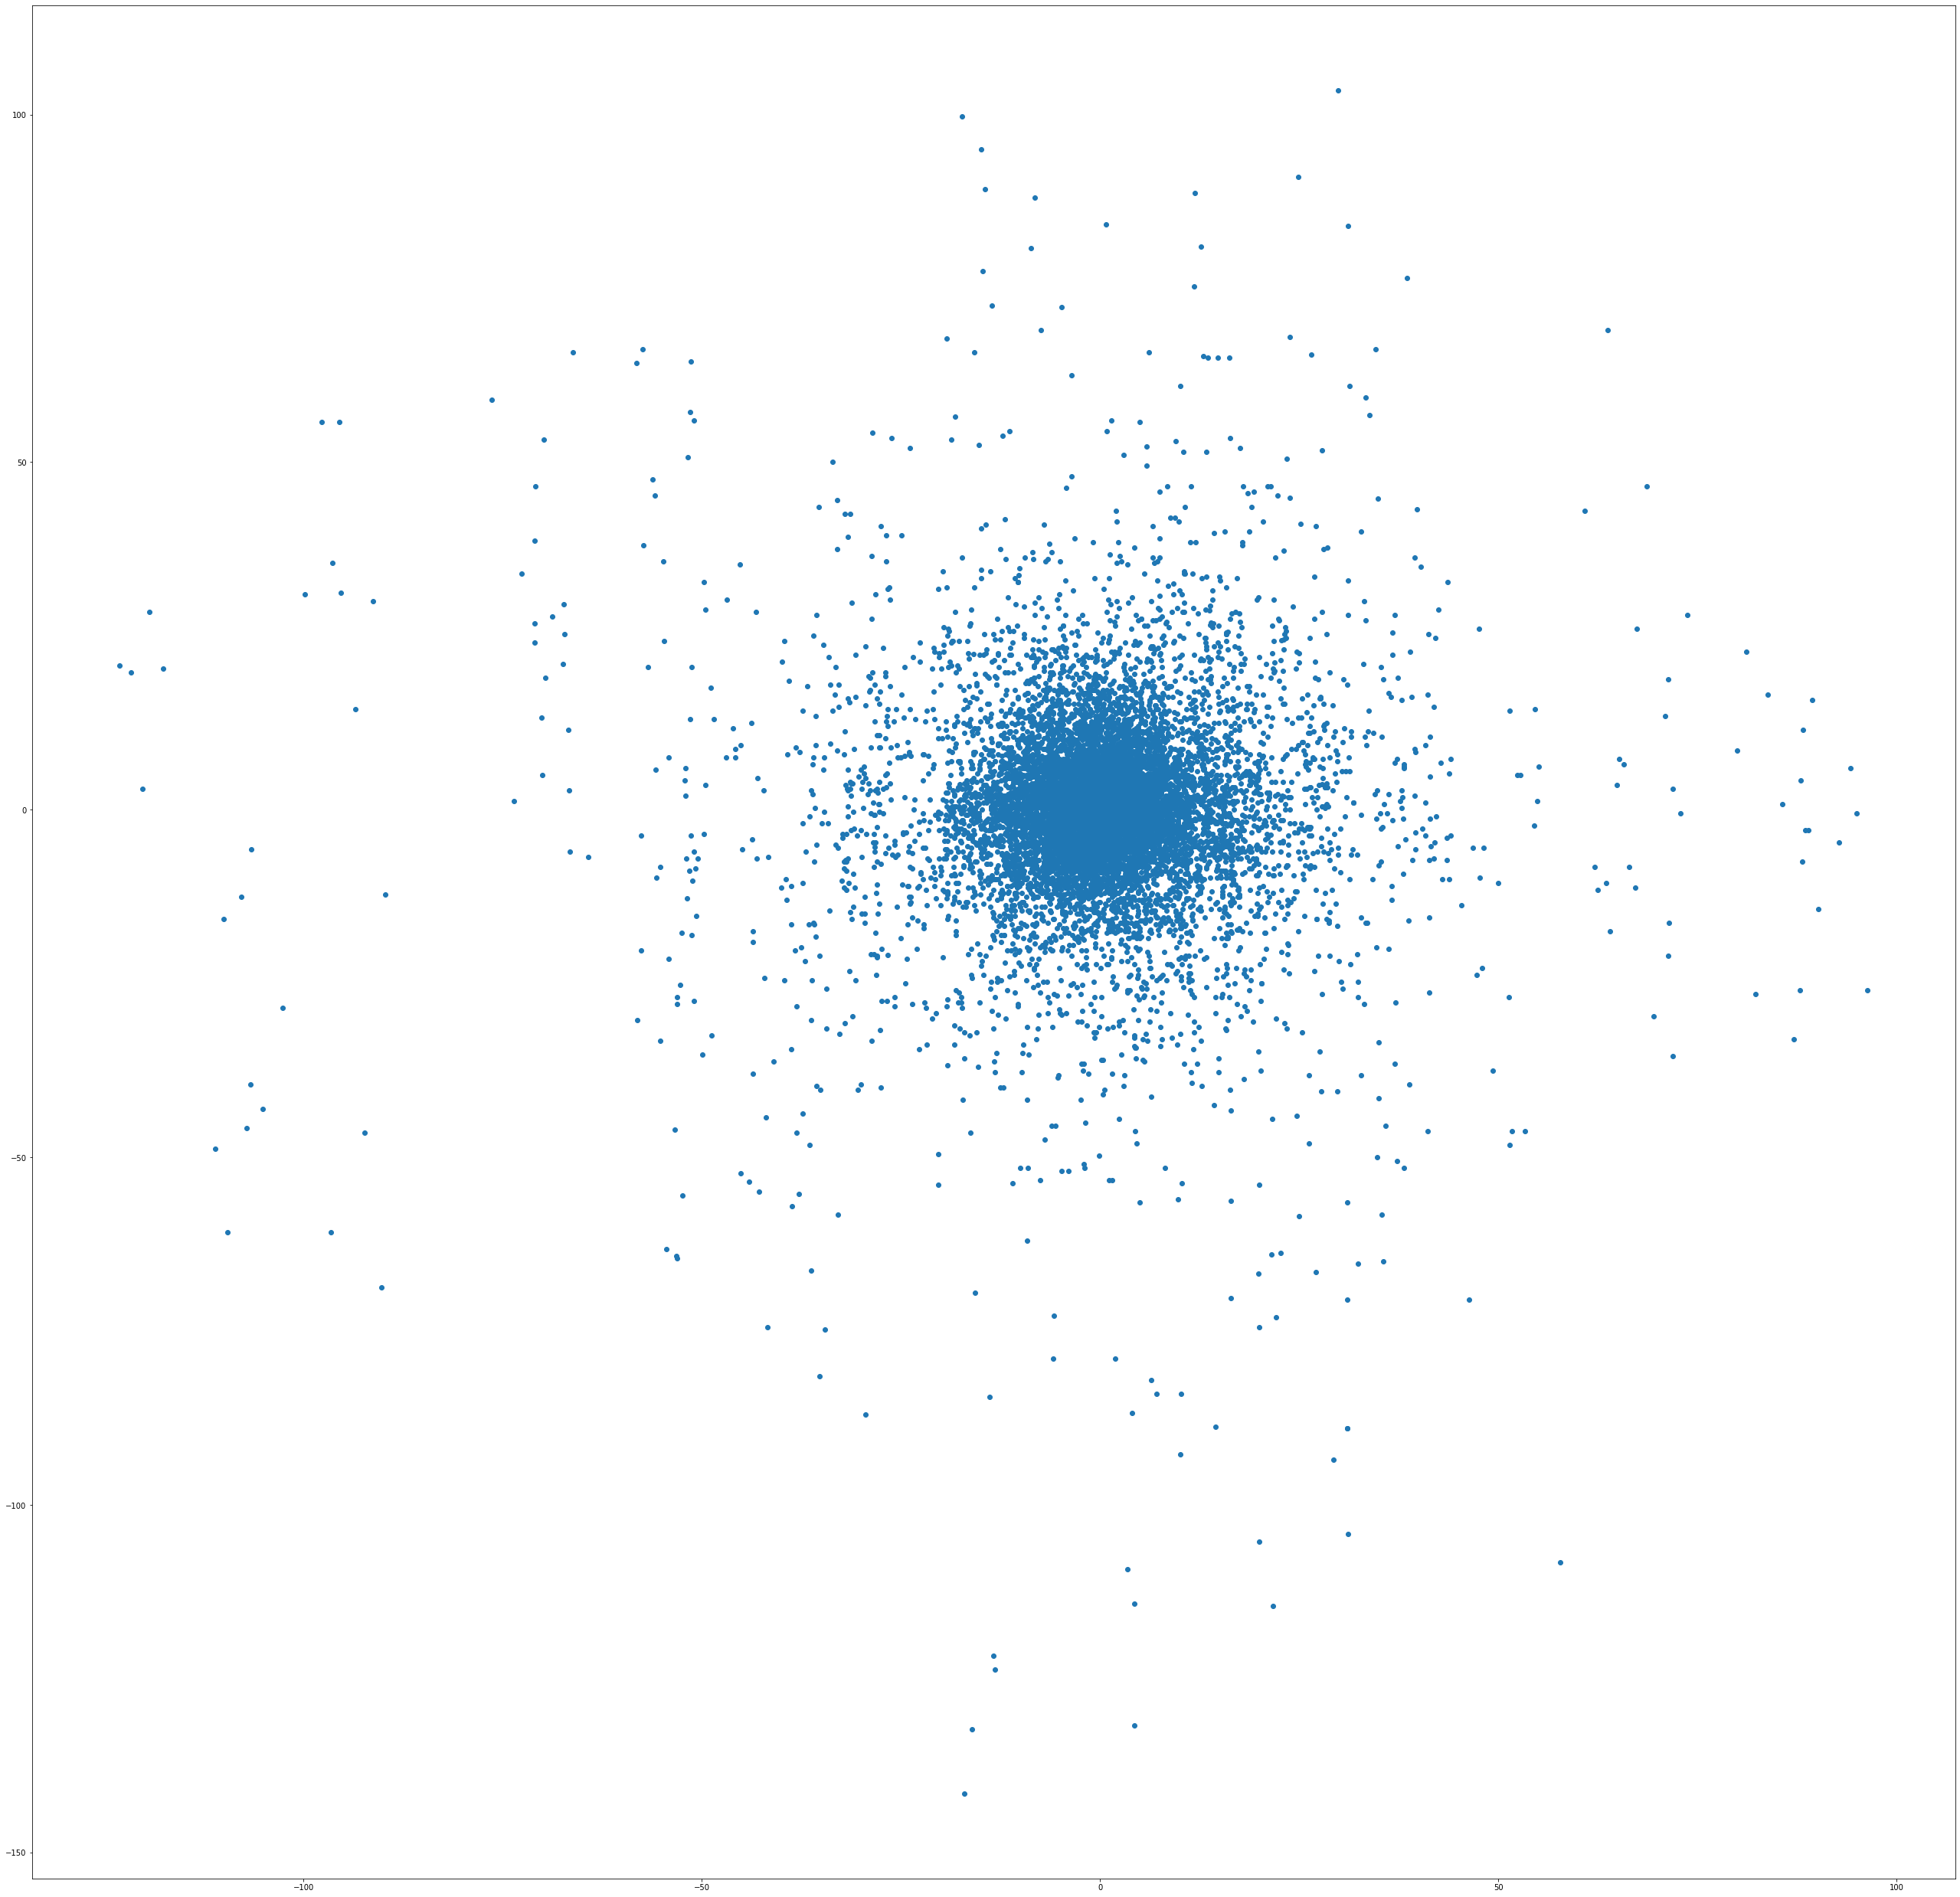

In [ ]:
plt.figure(figsize=(45,45))

plt.scatter(scatter_df['pointForecast'].diff(5),scatter_df['close'].diff(5))

plt.show()

# Forecasts

In [44]:
df2 = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\Output\arma\soybeans\forecasts.csv',parse_dates=True,index_col='asofdate')

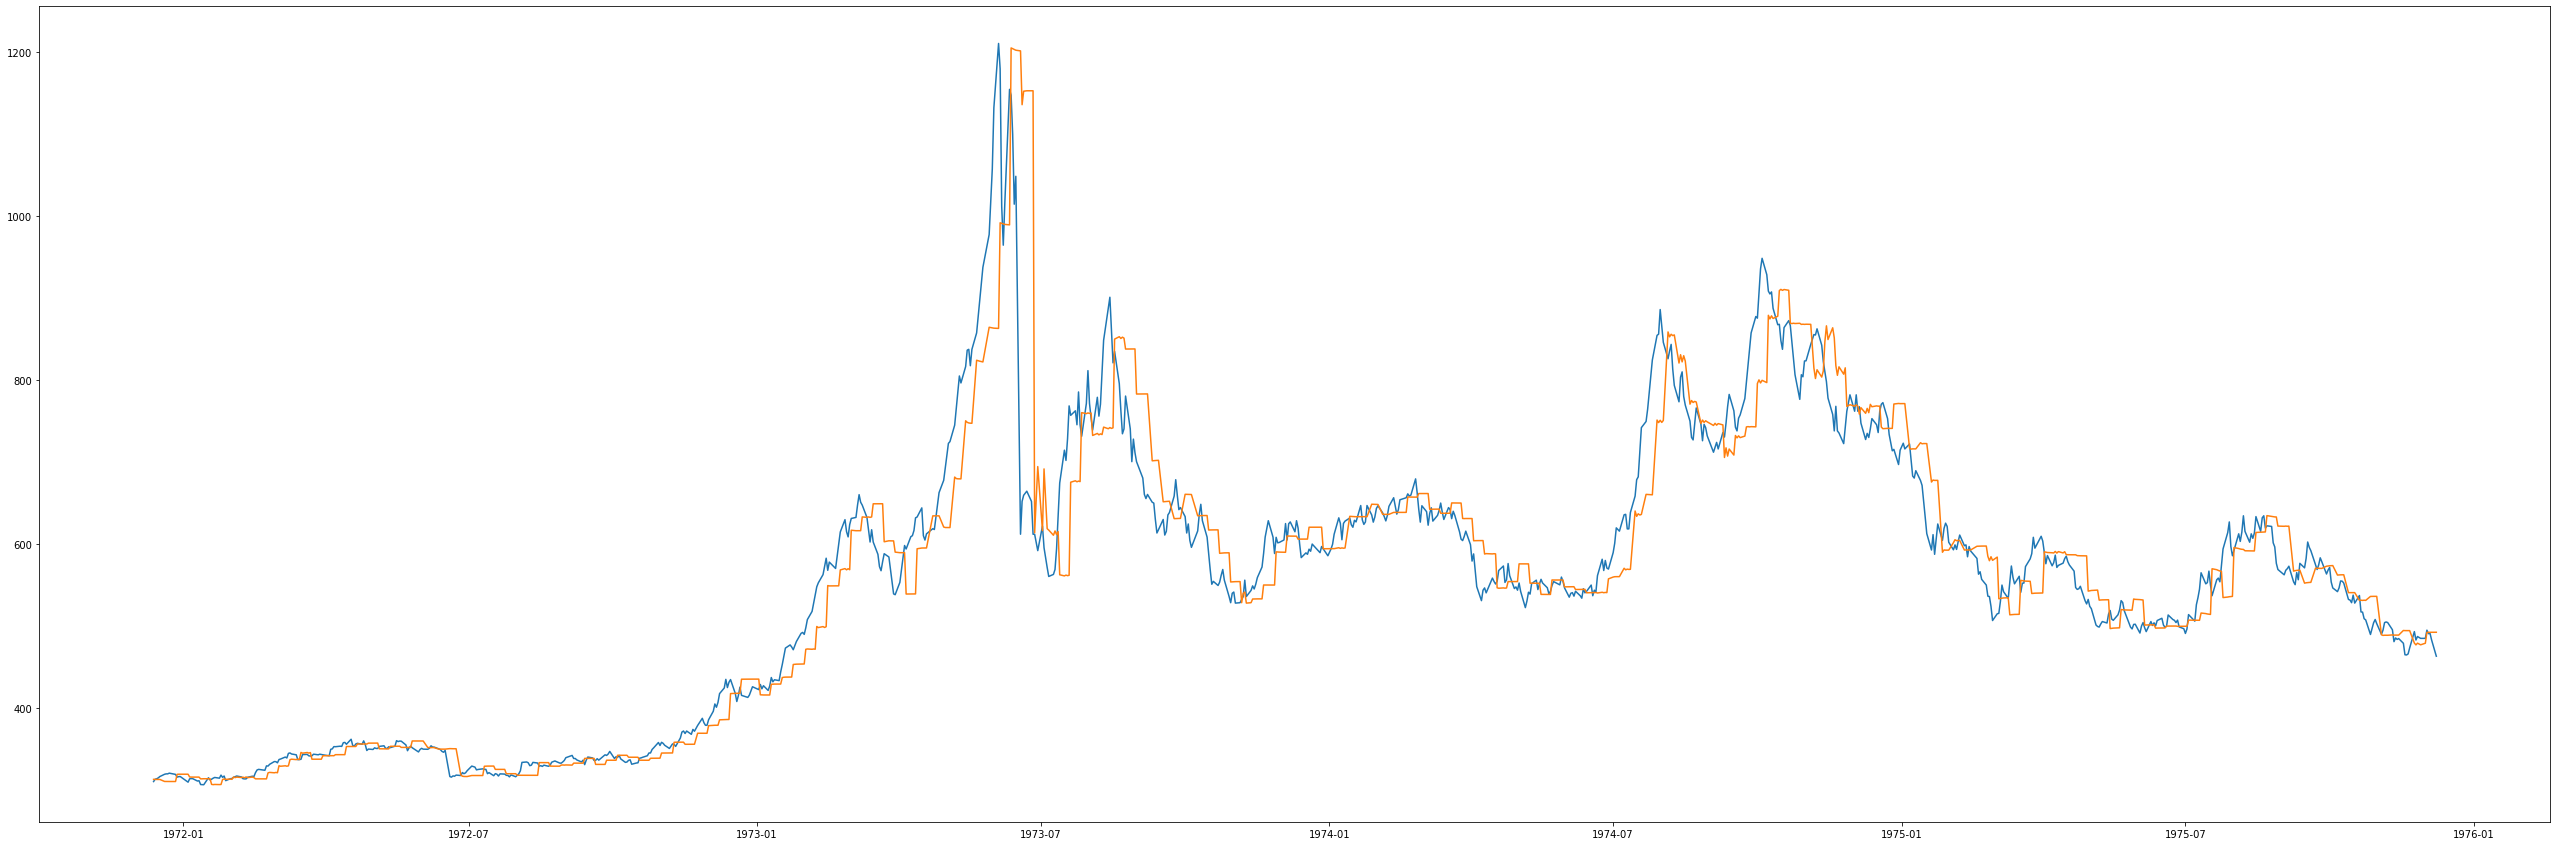

In [45]:
plt.figure(figsize=(45,15))

plt.plot(df2['close'][500:1500])
plt.plot(df2['pointForecast'][500:1500])

plt.show()
